In [1]:
import matplotlib.pyplot as plt
import numpy as np
from SVM import Svm
import utils as ut
import json

In [5]:
# process data and save them in .npy files in the './Processed/' folder
PCA = 0.95
ut.process_data(PCA,False)

### Load Data and Choose 2 Classes

Preprocessed data with MinMaxScaler and PCA(0.95).
We pick class T-Shirts and class Boots.


In [7]:
x_train = np.load(f'Processed/x_train_{PCA}.npy')
x_test = np.load(f'Processed/x_test_{PCA}.npy')
y_train = np.load('Processed/y_train.npy')
y_test = np.load('Processed/y_test.npy')

class1 = 0
class2 = 9
ind = np.logical_or(y_train == class1, y_train == class2)
x_train = x_train[ind]
y_train = y_train[ind]
y_train[y_train == class1] = 1
y_train[y_train == class2] = -1

ind = np.logical_or(y_test == class1, y_test == class2)
x_test = x_test[ind]
y_test = y_test[ind]
y_test[y_test == class1] = 1
y_test[y_test == class2] = -1

### Linear Kernel Grid Search

Training data size is (12000,188).
Validation is done with 5-Fold Validation

In [47]:
cs = [0.01, 0.1, 1, 10, 100, 1000]
kernel = 'linear'

In [48]:
res = ut.grid_search(cs, x_train, y_train, kernel)

Training: #0
                                                                                                                                                                                                                              
Cost: 0.058, Accuracies: 0.999, 0.999, Time: 4.026
Training: #1
                                                                                                                                                                                                                             
Cost: -1.725, Accuracies: 0.952, 0.951, Time: 59.339
Training: #2
                                                                                                                                                                                                                            
Cost: 13.855, Accuracies: 0.539, 0.534, Time: 142.093
Training: #3
                                                                                                                            

### Plot Linear Search

Unpack statistics from grid search and plot mean test accuracies

In [50]:
json_file = open('./linear_search.json')
lin_res_dict = json.load(json_file)
res = [list(d.values()) for d in lin_res_dict.values()]

In [51]:
cost, acc, time = zip(*res)
acc = np.asarray(acc)
import seaborn as sns
import pandas as pd

data = pd.DataFrame(data=acc.T, columns=cs)

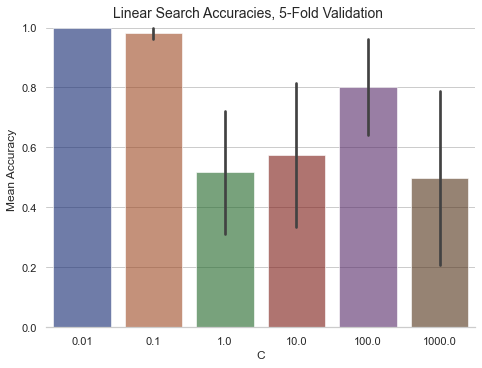

In [52]:
cols = [f"C = {c}" for c in cs]
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=data, kind="bar",
    ci="sd", palette="dark", alpha=.6, aspect=4 / 3, height=5, legend=False
)

g.despine(left=True)
g.set_axis_labels("C", "Mean Accuracy")
g.fig.suptitle("Linear Search Accuracies, 5-Fold Validation",
    fontsize=14, fontdict={"weight": "bold"})
g.savefig('./Plots/linear_search.svg', dpi=300, format='svg')

We see that C = 0.01 gives the best results.

So we train a linear SVM with C = 0.01 and validate it with the test data (x_test,y_test).

In [12]:
import time
svm_l001 = Svm(0.01, 'linear')
tr_acc, tr_elapsed = svm_l001.fit(x_train.T, y_train)
start = time.perf_counter()
_v, _l, te_acc = svm_l001.predict(x_test.T, y_test)
end = time.perf_counter()
print(f"Training time: {tr_elapsed:.3f}, Predict Time: {end-start:.3f}\nTest Accuracy: {te_acc}\nnSV: {svm_l001.sv.size}, #iters: {svm_l001.iters}")

Training time: 7.863, Predict Time: 0.003
Test Accuracy: 0.9995
nSV: 81, #iters: 46


## Radial Kernel Grid Search

Each point in the grid is validated with K-Fold Validation for k = 5.
Increase tolerance to 0.01 for decreased training time.
Max iterations = 1000


In [37]:
gs = [0.001, 0.01, 0.1]
cs2 = [0.1, 1, 10]
kernel2 = 'radial'
x, y = np.meshgrid(cs2, gs)
grid = np.array([x.ravel(), y.ravel()])

In [64]:
#WARNING: this search takes over 3 hours, do not run. The results are saved in 'radial_search.json', just run the next cell
res_radial3 = ut.grid_search(grid, x_train, y_train, kernel2, tol=0.01)

Training: #0
Model: radial, C: 0.1, gamma: 0.001                                                                                                                                                                                                                       
Cost: -8537.282, Accuracies: 0.649, 0.644, Time: 10.289
Training: #1
Model: radial, C: 1.0, gamma: 0.001                                                                                                                                                                                                                       
Cost: -66038.295, Accuracies: 0.784, 0.782, Time: 3.997
Training: #2
Model: radial, C: 10.0, gamma: 0.001                                                                                                                                                                                                                      
Cost: -272809.385, Accuracies: 0.918, 0.917, Time: 18.957
Training: #3
Model: radial, C: 0.1, ga

### Plot Radial Grid Search

In [38]:
# RUN THIS CELL TO GET THE SAVED RESULTS OF THE GRID SEARCH.
json_file = open('./radial_search.json')
rad_res_dict = json.load(json_file)
res_radial3 = [list(d.values()) for d in rad_res_dict.values()]


In [39]:
cost2, acc2, time2 = zip(*res_radial3)
acc2 = np.asarray(acc2)
time2 = np.asarray(time2)

acc2mean = acc2.mean(axis=1)
acc2std = acc2.std(axis=1)
time2mean = time2.mean(axis=1)
# acc2mean = acc2mean.reshape(3,3)

data2 = np.array([grid[0], grid[1], acc2mean, acc2std, time2mean]).T
dt2 = pd.DataFrame(data=data2, columns=['C', 'gamma', 'accuracy', 'std', 'time'])

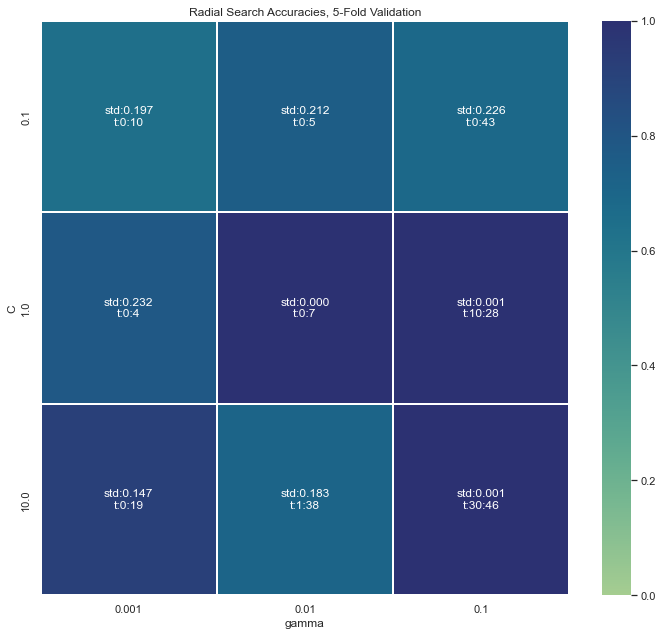

In [49]:
an = np.asarray([f"std:{s:.3f}\nt:{t // 60:.0f}:{t % 60:.0f}" for s, t in zip(dt2['std'], dt2['time'])]).reshape(3, 3).T
fig2, ax2 = plt.subplots()
fig2.set(figheight=9,figwidth=10)
ax2 = sns.heatmap(data=dt2.pivot('C', 'gamma', 'accuracy'), cmap='crest', annot=an, fmt='', vmin=0, vmax=1, ax=ax2, linewidth=0.1)
ax2.set_title("Radial Search Accuracies, 5-Fold Validation",
    fontsize=12)
fig2.tight_layout()
fig2.savefig('./Plots/radial_search.svg', dpi=300, format='svg')

C = 1.0 and gamma = 0.01 give the best results.

We train and validate.

In [298]:
svm_r0011 = Svm(1, 'radial', g=0.01)
tr_acc2, tr_elapsed2 = svm_r0011.fit(x_train.T, y_train)
start = time.perf_counter()
_v2, _l2, te_acc2 = svm_r0011.predict(x_test.T, y_test)
end = time.perf_counter()
print(f"Training time: {tr_elapsed2:.3f}, Predict Time: {end-start:.3f}\nTest Accuracy: {te_acc2}\nnSV: {svm_r0011.sv.size}, #iters: {svm_r0011.iters}")

Training time: 6.637, Predict Time: 0.009
Test Accuracy: 0.9995
nSV: 95, #iters: 43


### Compare Results with KNN, CN and libsvm

We train 3-NearestNeighbors, 1-NearestNeighbor and Nearest Centroid with the same data. We compare their results with our own SMV in test accuracy and training time.

Repeat the above process with libsvm's svm for both linear and radial kernels. We leave the default values for libsvm, which are C = 1 and gamma = 1/num_features

In [215]:
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

knn3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn1 = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
cn = NearestCentroid()

classifiers = [cn, knn1, knn3]

In [216]:
from sklearn.metrics import confusion_matrix
import time

for c in classifiers:
    start = time.perf_counter()
    c.fit(x_train, y_train)
    end = time.perf_counter()
    y_pred = c.predict(x_test)
    end2 = time.perf_counter()
    cm = confusion_matrix(y_test, y_pred, normalize='all')
    acc = 100 * cm.trace()
    fit_time = end - start
    pred_time = end2 - end
    print(f"Accuracy: {acc}, Fit time: {fit_time:0.3f}, Predict time: {pred_time:0.3f}")


Accuracy: 99.3, Fit time: 0.017, Predict time: 0.004
Accuracy: 99.9, Fit time: 0.004, Predict time: 0.458
Accuracy: 99.85, Fit time: 0.003, Predict time: 0.511


In [217]:
import libsvm.svmutil as sv

SVM = sv.svm_train(y_train, x_train)

In [218]:
p_label, p_acc, p_val = sv.svm_predict(y_test, x_test, SVM)

p_acc

Accuracy = 99.95% (1999/2000) (classification)


### Different Classes for  Classification

Class 1 is T-Shirts with label y = -1
Class 2 is Coat with label y = 1

In [312]:

x_train2 = np.load('Processed/x_train_0.95.npy')
x_test2 = np.load('Processed/x_test_0.95.npy')
y_train2 = np.load('Processed/y_train_0.95.npy')
y_test2 = np.load('Processed/y_test_0.95.npy')

class1 = 0
class2 = 4

ind1 = y_train2 ==class1
ind2 = y_train2 ==class2
y_train2 = np.ones(y_train2.shape)
y_train2[ind1] = -1
ind12 = np.logical_or(ind1,ind2)
y_train2 = y_train2[ind12]
x_train2 = x_train2[ind12]

ind1 = y_test2==class1
ind2 = y_test2==class2
y_test2 = np.ones(y_test2.shape)
y_test2[ind1] = -1
ind12 = np.logical_or(ind1,ind2)
y_test2 = y_test2[ind12]
x_test2 = x_test2[ind12]

In [338]:
difl_svm = Svm(0.01,'linear',max_iter=5000)
tr_acc_m,te_acc_m,tr_elapsed_m= ut.validate(difl_svm,x_train2,y_train2,x_test2,y_test2,25,'C:0.1')


Model:  C:0.1  Passes:  25
Training Acc: 0.719,Testing Acc: 0.715 Time: 5.045
SV size:  585


In [334]:
difr_svm = Svm(10,'radial',g=0.001)
tr_acc_d,te_acc_d,tr_elapsed_d= ut.validate(difr_svm,x_train2,y_train2,x_test2,y_test2,25,'C:10, g:0.001')
# print(f"Training: Accuracy: {tr_acc_d:.3f}, Time: {tr_elapsed_d:.3f}s")
# print(f"nSV: {difr_svm.sv.size}, #iter: {difr_svm.iters}")
# print(f"Testing Accuracy: {te_acc_d:.3f}")


Model:  C:10, g:0.001  Passes:  25
Training Acc: 0.843,Testing Acc: 0.842 Time: 9.595
SV size:  487


In [315]:
start = time.perf_counter()
SVM = sv.svm_train(y_train2,x_train2,'-t 0')
end = time.perf_counter()

p_label2,p_acc2,p_val2 = sv.svm_predict(y_test2,x_test2,SVM)
end2 = time.perf_counter()

print(f"Training time: {end-start:.3f}, Predict time: {end2-end:.3f}")

Accuracy = 98.25% (1965/2000) (classification)
Training time: 5.433, Predict time: 0.467


In [341]:
start = time.perf_counter()
SVM2 = sv.svm_train(y_train2,x_train2)
end = time.perf_counter()

p_label3,p_acc3,p_val3 = sv.svm_predict(y_test2,x_test2,SVM2)
end2 = time.perf_counter()

print(f"Training time: {end-start:.3f}, Predict time: {end2-end:.3f}")

Accuracy = 98.9% (1978/2000) (classification)
Training time: 5.131, Predict time: 0.683
